In [107]:
from scraper.youtube_comments_scraper import YoutubeCommentsScraper
from configparser import ConfigParser
import pandas as pd
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from konlpy.tag import Okt
import re
from collections import defaultdict
import spacy

os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk"

config = ConfigParser()
config.read("private/config.ini")

['private/config.ini']

In [108]:
from typing import Literal


API_KEY = config["youtube"]["api_key"]

KO_CHANNELS = [
    "UCcQTRi69dsVYHN3exePtZ1A",  # KBS
    "UCF4Wxdo3inmxP-Y59wXDsFw",  # MBC
    "UCkinYTS9IHqOEwR1Sze2JTw",  # SBS
    "UChlgI3UHCOnwUGzWzbJ3H5w",  # YTN
    "UCfq4V1DAuaojnr2ryvWNysw",  # Channel A
]

EN_CHANNELS = [
    "UC16niRr50-MSBwiO3YDb3RA", # BBC
    "UCupvZG-5ko_eiXAupbDfxWw", # CNN
    "UCBi2mrWuNuyYy4gbM6fU18Q", # ABC
    "UCNye-wNBqNL5ZzHSJj3l8Bg", # Al Jazeera
    "UCqnbDFdCpuN8CMEg0VuEBqA", # The New York Times
]

CHANNELS = EN_CHANNELS

FILE_PATH = "temp/youtube_news_comments_english.csv"

LANG: Literal['ko', 'en'] = 'en'

In [109]:
scraper = YoutubeCommentsScraper(API_KEY)

if os.path.exists(FILE_PATH):
    df = pd.read_csv(FILE_PATH, encoding="utf-8")
    print(f"Open existing file: {FILE_PATH}")
else:
    df = pd.DataFrame(scraper.scrape(CHANNELS, 50, 100, "date", "relevance"))
    df.to_csv(FILE_PATH, index=False, encoding="utf-8")
    print(f"Create new file: {FILE_PATH}")

Open existing file: temp/youtube_news_comments_english.csv


In [110]:
def ko_preprocessor(df: pd.DataFrame) -> dict[str, int]:
    """
    Preprocess Korean text and count the number of likes for each word.
    :param df: DataFrame with text and likes columns.
    :return: Dictionary with word and number of likes.
    """
    okt = Okt()
    word_dict = defaultdict(int)

    for _, row in df.iterrows():
        text = row["text"]
        likes = row["likes"]

        text = re.sub(r"<[^>]+>", "", text)
        text = re.sub(r"[^\w\s가-힣]", "", text)
        text = re.sub(r"http\S+|www.\S+", "", text)
        text = re.sub(r"\([^)]*\)", "", text)
        text = re.sub(r"\s+", " ", text).strip()

        words = okt.nouns(text)
        words = [word for word in words if len(word) > 1]

        for word in words:
            word_dict[word] += likes

    return dict(word_dict)


def en_preprocessor(df: pd.DataFrame) -> dict[str, int]:
    nlp = spacy.load('en_core_web_sm')
    word_dict = defaultdict(int)

    for _, row in df.iterrows():
        text = row["text"]
        likes = row["likes"]
        
        text = re.sub(r"<[^>]+>", "", text)
        text = re.sub(r"http\S+|www.\S+", "", text)
        text = re.sub(r"\([^)]*\)", "", text)
        text = re.sub(r"\s+", " ", text).strip()
        
        doc = nlp(text)
        
        words = [token.text for token in doc if token.pos_ in ['NOUN', 'PROPN'] and len(token.text) > 1]    
        
        # likes로 가중치 부여
        for word in words:
            word_dict[word] += likes
            
    return dict(word_dict)

In [111]:
def preprocessor(df: pd.DataFrame, lang: Literal['ko', 'en']) -> dict[str, int]:
    if lang == 'ko':
        return ko_preprocessor(df)
    elif lang == 'en':
        return en_preprocessor(df)

In [112]:
wordcloud = WordCloud(
    width=800,
    height=400,
    max_words=300,
    colormap="tab20c",
    font_path="/System/Library/Fonts/AppleSDGothicNeo.ttc",
)

In [113]:
word_dict = preprocessor(df, LANG)
wordcloud.generate_from_frequencies(word_dict)

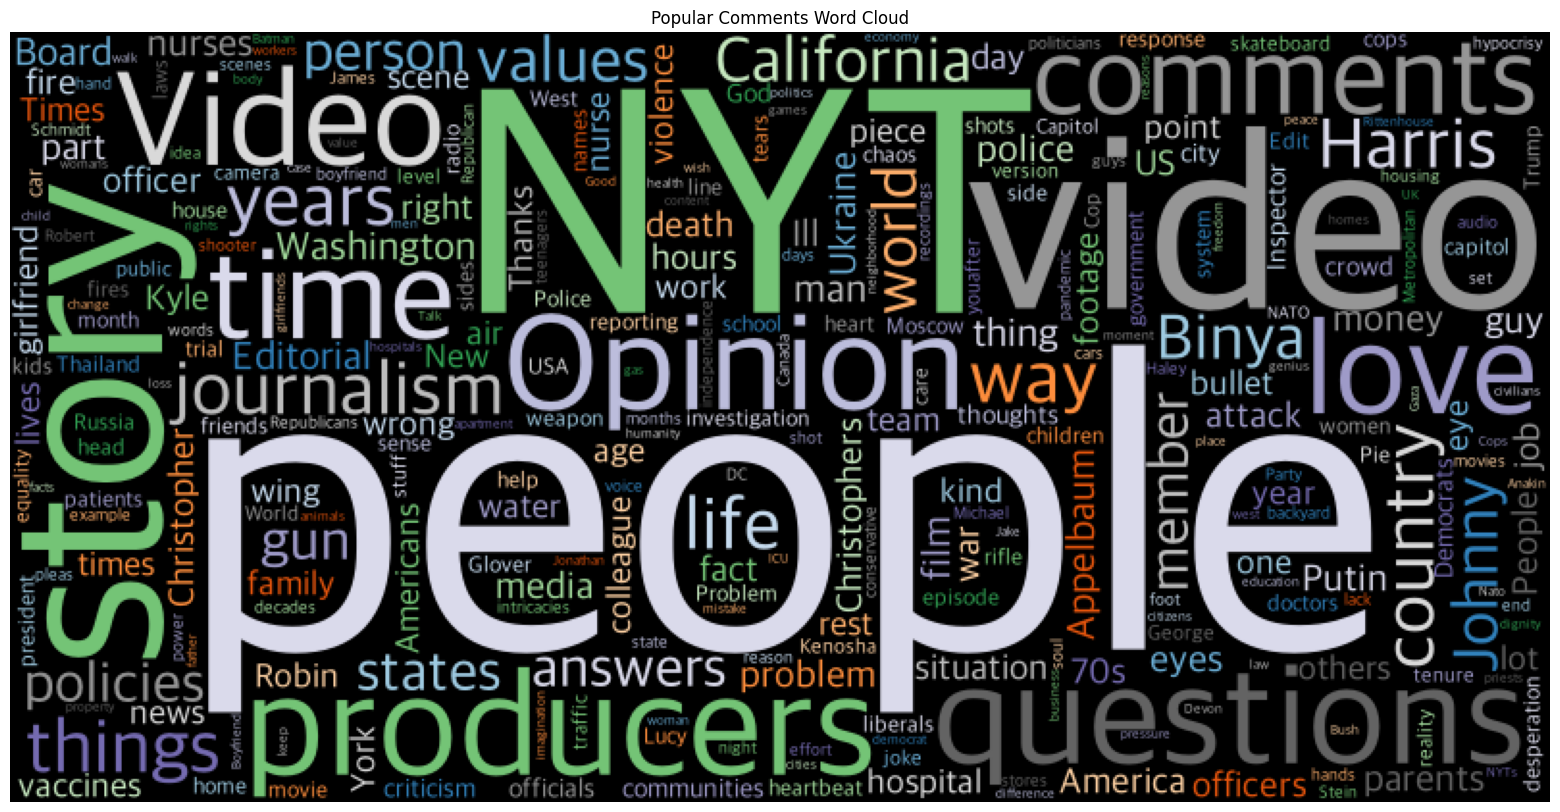

In [114]:
# Visualization
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Popular Comments Word Cloud")
plt.show()